# Imports

In [1]:
import time
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score,roc_curve, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql import SparkSession
from pyspark import StorageLevel
import pandas as pd


# Centralised Class

In [10]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict(w, b, X):
    z = np.dot(X, w) + b
    return 1 if sigmoid(z) > 0.5 else 0

class CentralisedLogisticRegression:
    @staticmethod
    def readFile(filename):
        data = pd.read_csv(filename)
        X = data.iloc[:, :-1].values  # All columns except last
        y = data.iloc[:, -1].values   # Last column
        return X, y
    
    @staticmethod
    def normalize(X):
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        return (X - mean) / std
    
    @staticmethod
    def train(X, y, iterations, learning_rate, lambda_reg):
        m, n = X.shape
        w = np.zeros(n)
        b = 0
        costs = []
        
        for i in range(iterations):
            # Forward propagation
            z = np.dot(X, w) + b
            y_pred = sigmoid(z)
            
            # Compute cost
            cost = (-1/m) * np.sum(y * np.log(y_pred) + (1-y) * np.log(1-y_pred)) + \
                   (lambda_reg/(2*m)) * np.sum(w**2)
            costs.append(cost)
            
            # Compute gradients
            dz = y_pred - y
            dw = (1/m) * np.dot(X.T, dz) + (lambda_reg/m) * w
            db = (1/m) * np.sum(dz)
            
            # Update parameters
            w = w - learning_rate * dw
            b = b - learning_rate * db
            
            if i % 2 == 0:
                print(f"Iteration {i}, Cost: {cost}")
                         
        return w, b, costs
    
    @staticmethod
    def accuracy(w, b, X, y):
        m = X.shape[0]
        predictions = np.array([predict(w, b, x) for x in X])
        return np.sum(predictions == y) / m




# Visualisation of input data

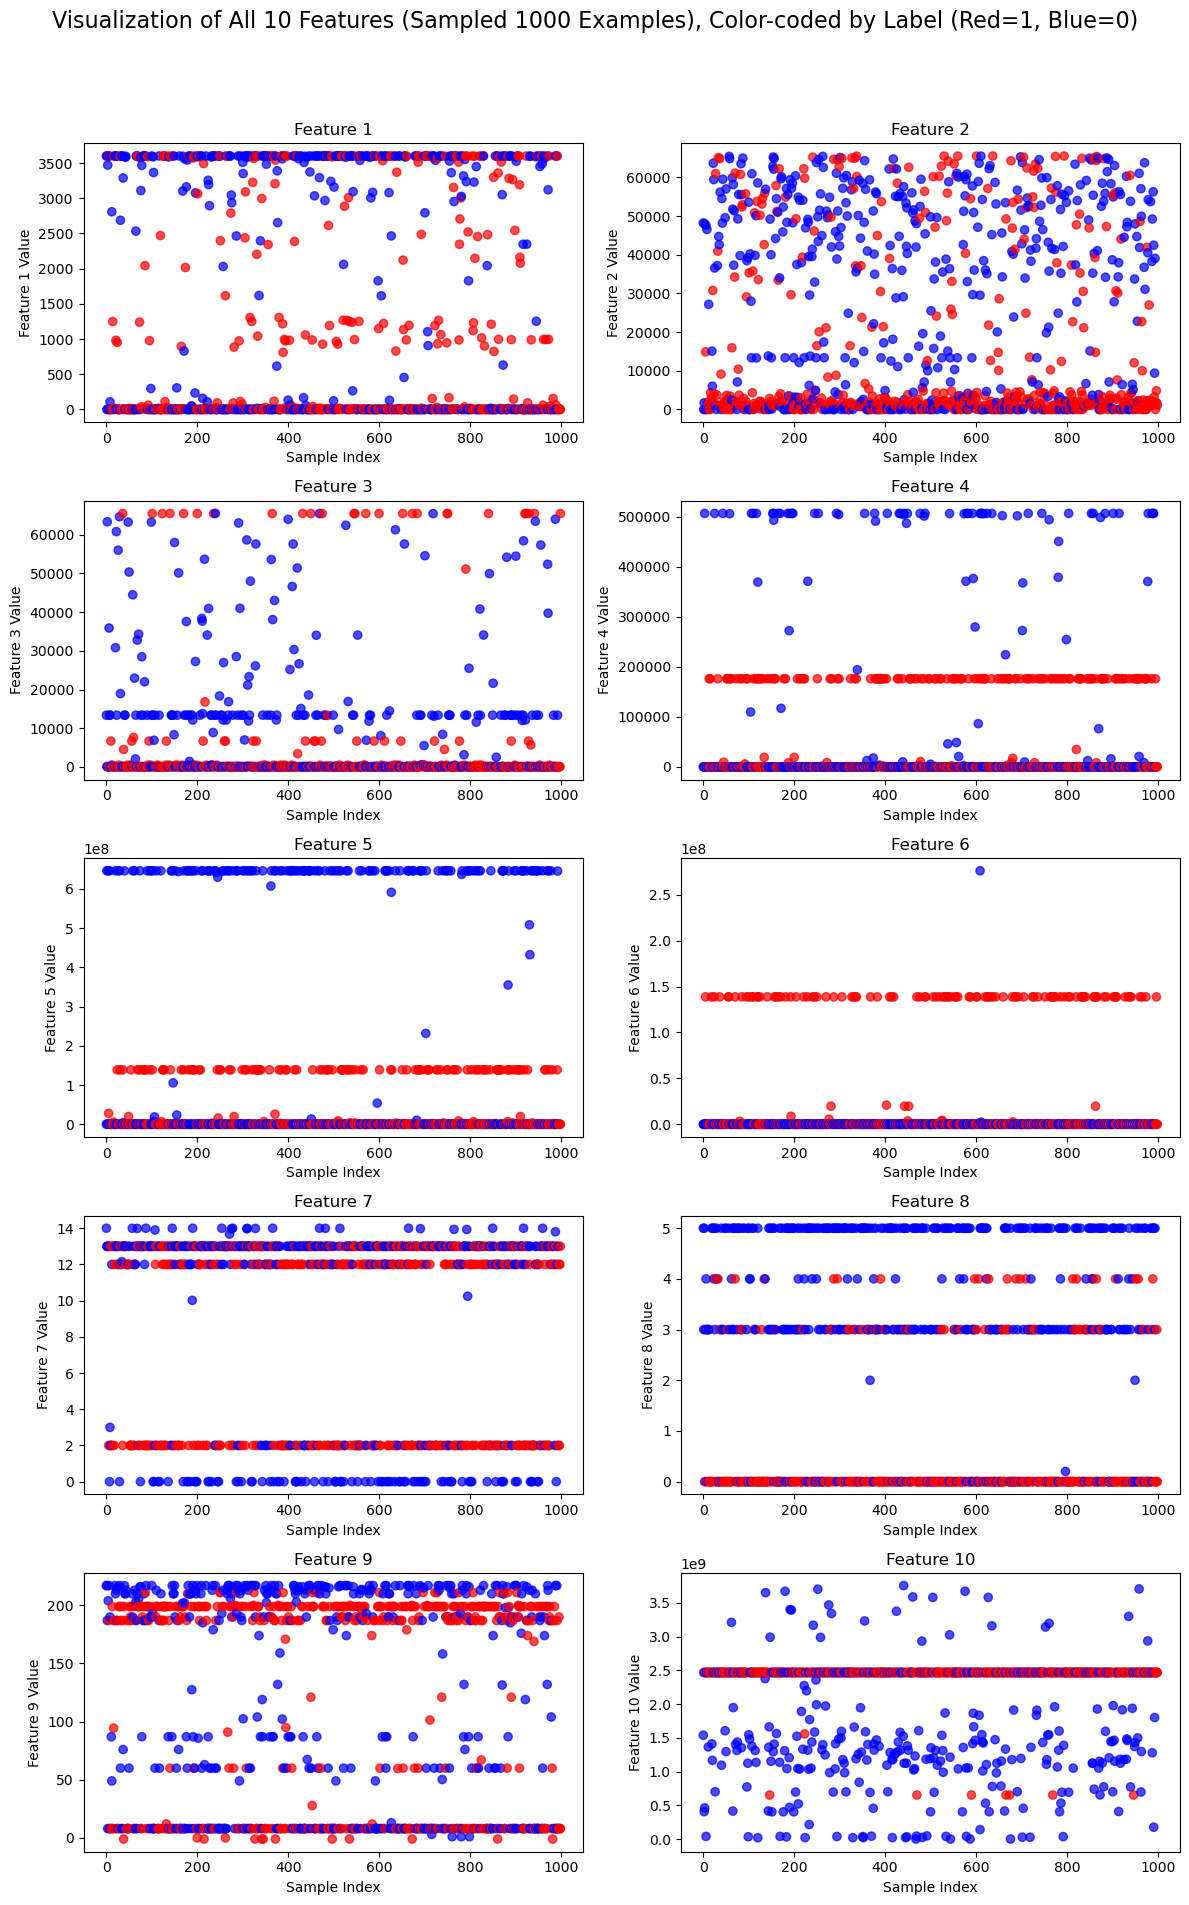

In [3]:
filename = 'botnet_tot_syn_l.csv'
X,y=CentralisedLogisticRegression.readFile(filename)

sample_size = min(1000, len(X)) 
X_sample = X[:sample_size, :]
y_sample = y[:sample_size]

# Plotting all 10 features of X_sample with colors based on labels in y_sample
fig, axes = plt.subplots(5, 2, figsize=(12, 20))
axes = axes.flatten()

for i in range(10):
    axes[i].scatter(range(len(X_sample)), X_sample[:, i], c=y_sample, cmap='bwr', alpha=0.7)
    axes[i].set_title(f"Feature {i + 1}")
    axes[i].set_xlabel("Sample Index")
    axes[i].set_ylabel(f"Feature {i + 1} Value")

plt.suptitle("Visualization of All 10 Features (Sampled 1000 Examples), Color-coded by Label (Red=1, Blue=0)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Evaluation Functions

In [4]:

def calculate_metrics(y_true, y_pred, y_prob):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_prob)
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Calculate ROC and Precision-Recall Curves
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_prob)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc_roc,
        'confusion_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'precision_curve': precision_curve,
        'recall_curve': recall_curve
    }

def plot_metrics(metrics):
    # Plot Confusion Matrix
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    # Plot ROC Curve
    plt.subplot(2, 2, 2)
    plt.plot(metrics['fpr'], metrics['tpr'], label=f"AUC = {metrics['auc_roc']:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    
    # Plot Precision-Recall Curve
    plt.subplot(2, 2, 3)
    plt.plot(metrics['recall_curve'], metrics['precision_curve'])
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    
    # Show summary metrics 
    plt.subplot(2, 2, 4)
    plt.axis("off")
    summary_text = f"Precision: {metrics['precision']:.2f}\n" \
                   f"Recall: {metrics['recall']:.2f}\n" \
                   f"F1 Score: {metrics['f1']:.2f}\n" \
                   f"AUC-ROC: {metrics['auc_roc']:.2f}"
    plt.text(0.1, 0.5, summary_text, fontsize=12, ha='left', va='center')
    
    plt.tight_layout()
    plt.show()


# Test / Main


Testing centralized version...
Iteration 0, Cost: 0.6931471805599461
Iteration 2, Cost: 0.6874750771462298
Iteration 4, Cost: 0.681905728132988
Iteration 6, Cost: 0.6764371305866588
Iteration 8, Cost: 0.6710673022333483
Centralized version execution time 11.986091375350952


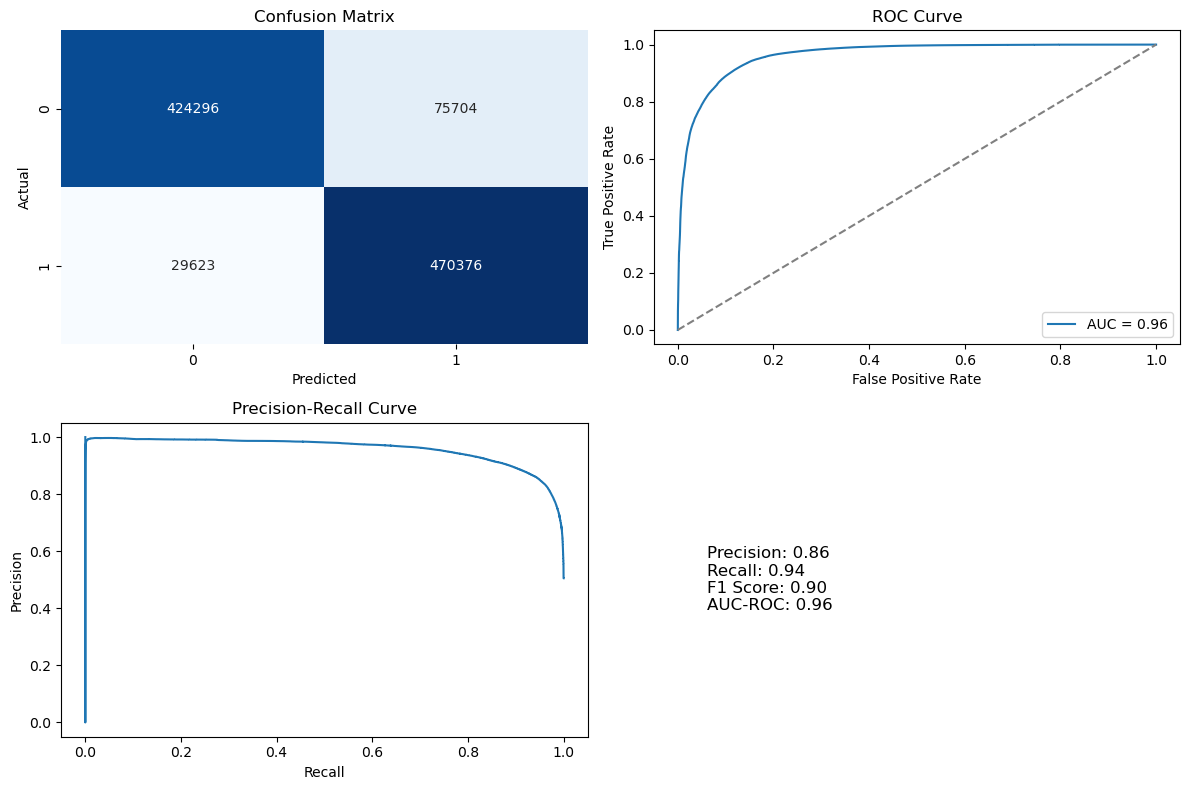

In [11]:
filename = 'botnet_tot_syn_l.csv'
print("Testing centralized version...")
start_time=time.time()

X, y = CentralisedLogisticRegression.readFile(filename)
X_norm = CentralisedLogisticRegression.normalize(X)
w, b, _ = CentralisedLogisticRegression.train(X_norm, y, iterations=10, learning_rate=0.01, lambda_reg=0.1)
y_pred = np.array([predict(w, b, x) for x in X_norm])
y_prob = np.array([sigmoid(np.dot(x, w) + b) for x in X_norm])

end_time=time.time()
execution_time = end_time - start_time
print(f"Centralized version execution time {execution_time}")


metrics = calculate_metrics(y, y_pred, y_prob)
plot_metrics(metrics)